## Overview

In this notebook, we will run through the NVIDIA AI Blueprint "[Build an Enterprise RAG pipeline](https://build.nvidia.com/nvidia/build-an-enterprise-rag-pipeline)"
We will walk through the steps from deployment to experiencing the RAG pipeline as a user.

### Retrieval Augmented Generation (RAG)
#### Importance

Retrieval-Augmented Generation (RAG) is an AI technique that enhances language model responses by retrieving relevant information from an external knowledge base before generating an answer. Instead of relying solely on what the model was trained on, RAG fetches up-to-date or domain-specific context—like documents or structured data—based on the user’s query. This improves accuracy, reduces hallucinations, and allows models to handle tasks requiring current or specialized knowledge.

#### Key Components of a RAG system 

**Ingestion of documents**

Document ingestion involves identifying the various modalities present—such as text, images, infographics, and charts—and extracting each accordingly. The extracted elements are then processed using methods best suited to their specific modality and transformed into vector embeddings, which are numerical representations that capture the semantic meaning of the content. These embeddings are subsequently stored in a vector database for efficient retrieval.

**Semantic Retrieval and Response Generation Pipeline**

The query/response pipeline begins by converting a user’s question into a vector embedding that captures its semantic meaning. This embedding is used to retrieve the most relevant content from a vector database. The retrieved results are then reranked to prioritize the most contextually appropriate information. Finally, a large language model (LLM) uses this context to generate a clear, accurate, and grounded response.

Both data and queries are encoded as vectors through an embedding process, enabling efficient similarity search based on semantic meaning rather than simple keyword matching.

## Table of Contents

1. **Check System Prerequisites** - Verify hardware and software requirements
2. **Deploy the RAG Blueprint** - Set up Docker containers and deploy services 
3. **Interact with the Microservices** - Test API endpoints and microservices
4. **Interact with the Chatbot** - Use the chatbot with and without knowledge base
5. **Understanding Document Retrieval and Reranking** - Understand how the RAG Pipeline works

## 1. Check System Prerequisites

Before deploying the blueprint, we need to ensure your system meets the specific hardware and software requirements.

In [ ]:
import sys
!{sys.executable} -m ensurepip --upgrade
!{sys.executable} -m pip install python-dotenv

Restart the kernel

In [ ]:
from IPython.display import clear_output
clear_output(wait=True)

import IPython
IPython.Application.instance().kernel.do_shutdown(True)

### 1.1 Check the OS version
* Should be Ubuntu 22.04

In [ ]:
!lsb_release -a

### 1.2 List the GPUs seen by the Linux kernel
* For a 2XH100, you should see 2 GPUs. 

In [ ]:
!lspci | grep -i nvidia

### 1.3 Check the NVIDIA Linux GPU driver version
* This should be "NVIDIA Linux GPU driver version 550" or higher

In [ ]:
!nvidia-smi -q | grep -i "Driver Version"

### 1.4 Check the installed CUDA version
* This should be 12.4 or higher

In [ ]:
!nvidia-smi -q | grep -i "CUDA Version"

### 1.5 Verify that the NVIDIA driver is loaded correctly
You should see something like 
```
GPU 0: NVIDIA H100 NVL (UUID: GPU-6d4c2521-d171-1aca-760c-8c662a7efbda)
GPU 1: NVIDIA H100 NVL (UUID: GPU-711408b5-8d75-664a-a26a-6df51935d1f0)
```

In [ ]:
!nvidia-smi -L

### 1.6 Check amount of free memory

In [ ]:
!free -g

### 1.7 Docker and Docker compose version

* Docker should have a minimum version of 26.0
* Docker Compose should have a minimum version of 2.17

In [ ]:
!docker --version
!docker compose version

### 1.8 Check the NVIDIA Container toolkit version
* NVIDIA container toolkit should have a minimum version of 1.14.6

In [ ]:
!nvidia-container-toolkit -version

### 1.9 Make sure NVIDIA is the default container runtime

In [ ]:
!grep default /etc/docker/daemon.json

### 1.10 Use Docker run to ensure the GPU is properly exposed to the container runtime
You should see something like 
```+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                Off |   00000000:17:00.0 Off |                    0 |
| N/A   43C    P0             95W /  400W |   46678MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+------------------------+----------------------+
|   1  NVIDIA H100 NVL                Off |   00000000:63:00.0 Off |                    0 |
| N/A   41C    P0             91W /  400W |   90994MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI              PID   Type   Process name                        GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|  No running processes found                                                             |
+-----------------------------------------------------------------------------------------+
```

In [ ]:
!docker run --rm --runtime=nvidia --gpus all ubuntu nvidia-smi

## 2. Deploy the blueprint

The next few cells deploy the blueprint using docker compose. 

### 2.1 Clone the github repository

https://github.com/NVIDIA-AI-Blueprints/rag.git

In [ ]:
!git clone -b v2.2.1 https://github.com/NVIDIA-AI-Blueprints/rag.git

In [ ]:
import os
os.chdir('rag')

### 2.2 Getting your API key

You need to generate an API key
to access NIM services, to access models hosted in the NVIDIA API Catalog, and to download models on-premises.
For more information, refer to [NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-private-registry-user-guide/index.html#ngc-api-keys).

To generate an API key, use the following procedure.

1. Go to https://org.ngc.nvidia.com/setup/api-keys.
2. Click **+ Generate Personal Key**.
3. Enter a **Key Name**.
4. For **Services Included**, select **NGC Catalog** and **Public API Endpoints**.
5. Click **Generate Personal Key**.

After you generate your key, export your key as an environment variable by using the following code.

```bash
export NGC_API_KEY="<your-ngc-api-key>"
```
#### Setting Environment Variables

This notebook requires certain environment variables to be configured in a `.env` file.

In [ ]:
import getpass

# Step 1: Set API key in notebook environment
if not os.environ.get("NGC_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NGC API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NGC_API_KEY"] = nvapi_key
    print("✅ API key has been set in notebook environment")

### 2.3 Authenticate Docker with NGC
To pull images required by the blueprint from NGC, you must first authenticate Docker with NGC. Use the NGC API Key you created.

In [ ]:
!echo "${NGC_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin

### 2.4 Deploy the NVIDIA NIM Microservices

The next step launches the NVIDIA NIM microservices that power the RAG system. Each microservice handles a specific function in the overall architecture.

> 💡 **TIP**: For selective deployment, you can use:
> - `--profile rag` - Only start RAG-specific NIMs
> - `--profile ingest` - Only start ingestion-specific NIMs

In this notebook we'll be deploying all the NIMs (i.e. for both profiles)

#### ⚠️ Important Notes

1. **First-time startup**: The NeMo LLM service may take up to 30 minutes to start for the first time as the model is downloaded and cached.

2. **Wait for healthy status**: Before proceeding, ensure that these critical services show "(healthy)" status:
   - `nemoretriever-ranking-ms`
   - `nemoretriever-embedding-ms`
   - `nim-llm-ms`
   
3. **Cache location**: All models are downloaded and cached in the path specified by `MODEL_DIRECTORY`.

#### 2.4.1 Create a NIM cache directory
The code below creates a directory to cache the models and exports the path to the cache as an environment variable.

#### 2.4.2 Export the required environment variables to use locally hosted models.

* Review these files
  
  a. `deploy/compose/.env`  and
  
  b. The accuracy profile `deploy/compose/accuracy_profile.env`
* Source both files

In [ ]:
!mkdir -p ~/.cache/model-cache
# Create MODEL_DIRECTORY if not already set
if not os.environ.get("MODEL_DIRECTORY"):
    model_cache_dir = os.path.expanduser('~/.cache/model-cache')
    os.makedirs(model_cache_dir, exist_ok=True)
    os.environ["MODEL_DIRECTORY"] = model_cache_dir

#### 2.4.3 Deploy the NVIDIA NIM Microservices
Pull the NIM Microservice images from the NGC Container registry and deploy

IMPORTANT: The LLM NIM might need a different GPU configuration.
eg. On A100, the LLM NIM needs 2 GPUs 
On H100, the 1 GPU is sufficient. 

In [ ]:
import subprocess
import re

def get_gpu_models():
    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True
        )
        return result.stdout.strip().split("\n")
    except subprocess.CalledProcessError as e:
        print("Error running nvidia-smi:", e.stderr)
        return []

def check_gpu_type(models, target="A100"):
    return any(target in model for model in models)

def run_sed_command():
    try:
        subprocess.run(
            ["sed", "-i", "s/^export LLM_MS_GPU_ID=1$/export LLM_MS_GPU_ID=1,2/", "deploy/compose/.env"],
            check=True
        )
        print("Successfully updated .env for A100 GPUs.")
    except subprocess.CalledProcessError as e:
        print("Failed to run sed command:", e)

# Main logic
gpu_models = get_gpu_models()
if check_gpu_type(gpu_models, "A100"):
    print("A100 detected. Running sed command...")
    run_sed_command()
else:
    print("A100 not detected. No changes made.")

In [ ]:
from dotenv import load_dotenv
load_dotenv("deploy/compose/.env")
load_dotenv("deploy/compose/accuracy_profile.env")

In [ ]:
import subprocess
import os
import sys

print("Getting current user ID...", flush=True)
try:
    os.environ["USERID"] = subprocess.check_output("id -u", shell=True).decode().strip()
    print(f"✅ USERID set to {os.environ['USERID']}", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to get USERID.", file=sys.stderr)
    print(e.stderr if hasattr(e, 'stderr') else e.output, file=sys.stderr)
    sys.exit(1)

print("Pulling NIMS images...", flush=True)
try:
    pull_result = subprocess.run(
        ["docker", "compose", "-f", "deploy/compose/nims.yaml", "pull", "--quiet"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print("✅ NIMS images pulled successfully.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to pull NIMS images.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

print("Starting NIMS containers...", flush=True)
try:
    result = subprocess.run(
        ["docker", "compose", "-f", "deploy/compose/nims.yaml", "up", "-d"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print(result.stdout, flush=True)
    print("✅ NIMS containers started successfully.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to start NIMS containers.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

#### 2.4.4 Confirm all the below mentioned containers are running.
Run the following code to check the status of all containers:
use

```docker ps --format "table {{.ID}}\t{{.Names}}\t{{.Status}}\t{{.Ports}}" when running in shell``` 

In [ ]:
import subprocess
subprocess.run(['docker', 'ps', '--format', 'table {{.Names}}\t{{.Status}}'])

> Expected Output
```output
      NAMES                                   STATUS

      nemoretriever-ranking-ms                Up 14 minutes (healthy)
      compose-page-elements-1                 Up 14 minutes
      compose-paddle-1                        Up 14 minutes
      compose-graphic-elements-1              Up 14 minutes
      compose-table-structure-1               Up 14 minutes
      nemoretriever-embedding-ms              Up 14 minutes (healthy)
      nim-llm-ms                              Up 14 minutes (healthy)
   ```

### 2.5 Start the vector database containers
Next, we'll start the vector database containers which will persist the vector embeddings.
> **TIP**
> You can add a `--build` argument in case you have made some code changes or have any requirement of re-building ingestion containers from source code:

In [ ]:
import subprocess
import os
import sys

print("Pulling vector database images...", flush=True)
try:
    pull_result = subprocess.run(
        ["docker", "compose", "-f", "deploy/compose/vectordb.yaml", "pull", "--quiet"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print("✅ Images pulled successfully.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to pull images.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)  # Exit early since next step depends on successful pull

print("Starting vector database...", flush=True)
try:
    result = subprocess.run(
        ["docker", "compose", "-f", "deploy/compose/vectordb.yaml", "up", "-d"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print(result.stdout, flush=True)
    print("✅ Docker Compose is up and running.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Docker Compose failed.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

# Check running containers
subprocess.run(['docker', 'ps', '--format', 'table {{.Names}}\t{{.Status}}'])

### 2.6 Start the ingestion containers. 
Now we'll deploy the containers responsible for processing and ingesting documents into the vector database:
> **TIP**
> You can add a `--build` argument in case you have made some code changes or have any requirement of re-building ingestion containers from source code:

In [ ]:
import subprocess
import os
import sys

print("Pulling Ingestor Server images...", flush=True)
try:
    pull_result = subprocess.run(
        ["docker", "compose", "-f", "deploy/compose/docker-compose-ingestor-server.yaml", "pull", "--quiet"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print("✅ Ingestor images pulled successfully.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to pull Ingestor images.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

print("Starting Ingestor Server containers with build...", flush=True)
try:
    up_result = subprocess.run(
        ["docker", "compose", "-f", "deploy/compose/docker-compose-ingestor-server.yaml", "up", "-d"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print(up_result.stdout, flush=True)
    print("✅ Ingestor Server containers are up and running.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to start Ingestor Server containers.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

# Optionally check running containers
subprocess.run(
    ["docker", "ps", "--format", "table {{.Names}}\t{{.Status}}"],
    env=os.environ
)

### 2.7 Start for RAG Microservices:

Use the following procedure to start the RAG containers.
These containers expose the retrieval and answer generation endpoint for realising the end-to-end usecase.
> **TIP**
> You can add a `--build` argument in case you have made some code changes or have any requirement of re-building ingestion containers from source code:

In [ ]:
import subprocess
import os
import sys

compose_file = "deploy/compose/docker-compose-rag-server.yaml"

print("Pulling RAG microservice images...", flush=True)
try:
    pull_result = subprocess.run(
        ["docker", "compose", "-f", compose_file, "pull", "--quiet"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print("✅ RAG images pulled successfully.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to pull RAG images.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

print("Starting RAG microservices...", flush=True)
try:
    up_result = subprocess.run(
        ["docker", "compose", "-f", compose_file, "up", "-d"],
        env=os.environ,
        check=True,
        capture_output=True,
        text=True
    )
    print(up_result.stdout, flush=True)
    print("✅ RAG microservices are up and running.", flush=True)
except subprocess.CalledProcessError as e:
    print("❌ Failed to start RAG microservices.", file=sys.stderr)
    print(e.stderr, file=sys.stderr)
    sys.exit(1)

print("Started RAG Microservices", flush=True)
print("-" * 60, flush=True)

# Optional: Check running containers
subprocess.run(
    ["docker", "ps", "--format", "table {{.Names}}\t{{.Status}}"],
    env=os.environ
)

### 2.8 Ensure all the microservices and nims are running. 
You should see a total of 15 microservices
eg.
```docker ps --format "table {{.ID}}\t{{.Names}}\t{{.Status}}"
CONTAINER ID   NAMES                            STATUS
01196e59cd6f   rag-server                       Up 42 seconds
578e86a6d526   ingestor-server                  Up About a minute
26b0a6b9ecb9   compose-nv-ingest-ms-runtime-1   Up 3 minutes (healthy)
b69c68b9dd09   compose-redis-1                  Up 5 minutes
62a6734d53d3   milvus-standalone                Up 6 minutes
ca56c4e07df1   milvus-minio                     Up 6 minutes (healthy)
892889cdc094   milvus-etcd                      Up 6 minutes (healthy)
bd77efb39b90   nim-llm-ms                       Up 8 minutes (healthy)
c84bfd73c118   nemoretriever-ranking-ms         Up 10 minutes (healthy)
df4a5a2aebfd   compose-graphic-elements-1       Up 10 minutes
e7d5593c27b8   compose-page-elements-1          Up 10 minutes
8619fd2d1012   compose-paddle-1                 Up 10 minutes
dbf4c4e96340   nemoretriever-embedding-ms       Up 10 minutes (healthy)
371639aee5ad   compose-table-structure-1        Up 10 minutes
ca6fe2dd51ce   rag-playground                   Up 42 seconds
```

In [ ]:
%%capture
subprocess.run(
    ["docker", "ps", "--format", "table {{.ID}}\t{{.Names}}\t{{.Status}}"],
    env=os.environ
)

### 2.9 Ensure the LLM NIM is healthy.
#### 🛑⚠️ Do not proceed till the LLM NIM is healthy.

While we expect the LLM NIM to have started by the time you hit this cell, let's be absolutely certain this NIM is ready to serve

In [ ]:
import subprocess
import time

service_name = "nim-llm-ms"
max_retries = 60  # wait up to 60 x 35 = 2100 seconds
retry_interval = 35

for i in range(max_retries):
    result = subprocess.run(
        ["docker", "inspect", "--format", "{{.State.Health.Status}}", service_name],
        capture_output=True, text=True
    )
    status = result.stdout.strip()
    print(f"Attempt {i+1}: Service status = {status}")

    if status == "healthy":
        print("Service is healthy. Continuing...")
        break
    time.sleep(retry_interval)
else:
    raise TimeoutError(f"Service '{service_name}' did not become healthy after {max_retries * retry_interval} seconds.")


#### Ensure the LLM NIM status shows healthy

In [ ]:
# Ensure the status of the NIM looks like

import subprocess

container_name = "nim-llm-ms"

result = subprocess.run(
    ["docker", "ps", "--filter", f"name={container_name}", "--format", "{{.Status}}"],
    capture_output=True,
    text=True,
    env=os.environ
)

status = result.stdout.strip()
print(f"Status of '{container_name}': {status}")

### 2.10 Open the RAG Playground
Once all services are running, you can interact with the RAG Chatbot through its web interface.

#### Accessing the Playground

1. Open you launchable instance (back to where you started opened the notebook) and navigate to the Deployments section

2. Click the RAG playground "Shareable URL"

3. This should open the RAG Chatbot interface in a new browser tab

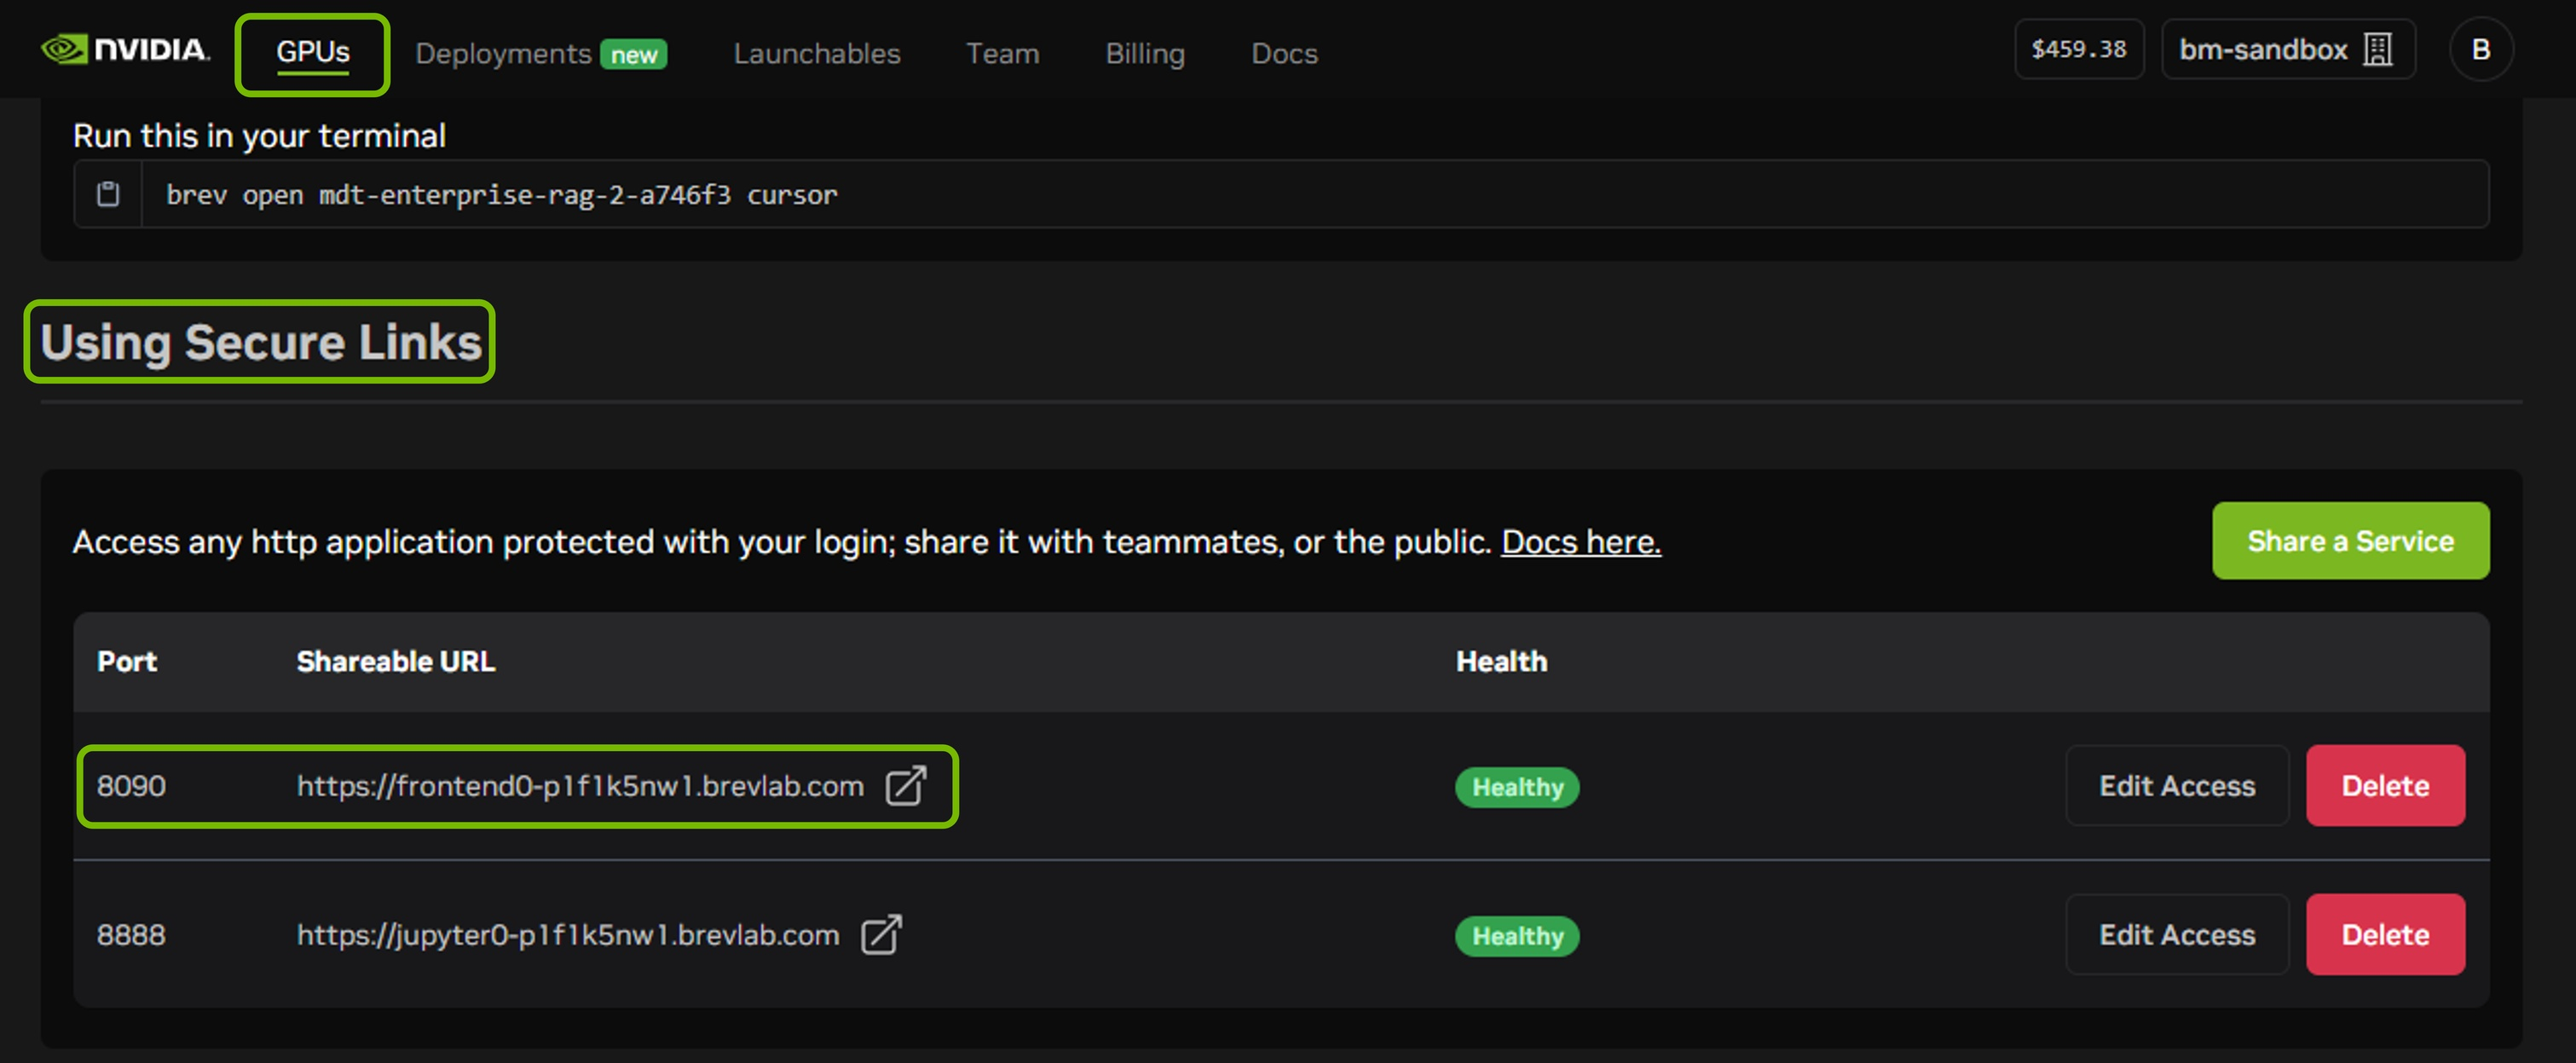


#### Testing the Chatbot

To evaluate how the RAG system works, try these experiments:

1. Create a new collection

2. Add source -- upload a document

3. Try asking a question about the document without selecting the new Collection (knowledge base off)

4. Ask a question with knowledge base on


## 3. Interact with the blueprint
In this section, we'll explore how to directly interact with the various microservices that make up our RAG system using their APIs.

### 3.1 RAG Server API Usage

#### 3.1.1 Test the OpenAI-compatible /chat/completions endpoint
- Ensure the "rag-server" container is running before executing the notebook by following the steps above.

- Replace `RAG_BASE_URL` with the actual server URL if the API is hosted on another system.

**3.1.1.1 RAG Server access.**

Here we will set up the configuration for the RAG server and a helper function to print the API responses.

In [ ]:
!pip install aiohttp

In [ ]:
import requests
import json
import aiohttp

# IP address assuming all services are local to server hosting the notebook
IPADDRESS = "0.0.0.0"

# Port number for the server
rag_server_port = "8081"

# Base URL constructed from IP and port for making API requests
RAG_BASE_URL = f"http://{IPADDRESS}:{rag_server_port}"

async def print_raw_response(response):
    """Helper function to print API responses.
    """
    try:
        response_json = await response.json()
        print(json.dumps(response_json, indent=2))
    except aiohttp.ClientResponseError:
        print(await response.text())

**3.1.1.2 Test the RAG server health endpoint and chat completion endpoint**

We will test both the health endpoint and chat completion functionality of our RAG server

- **Health Check Endpoint purpose:**
This endpoint performs a health check on the server. It returns a 200 status code if the server is operational.

- **Chat Completion Endpoint purpose:**
This endpoint accepts user queries and converts them to embeddings, then retrieves semantically similar document chunks from the knowledge base.

In [ ]:
# 1. Test the RAG server health endpoint to verify it's running properly
url = f"{RAG_BASE_URL}/v1/health"
print("\nStep 1: Testing RAG server health endpoint")
print("-"*60)
async with aiohttp.ClientSession() as session:
    async with session.get(url) as response:
        await print_raw_response(response)

# 2. Test basic chat completion endpoint without using the knowledge base
payload = {
    "messages": [
        {
            "role": "user",
            "content": "Hi"  # Simple test message
        }
    ],
    "use_knowledge_base": False,  # Disable RAG functionality
    "temperature": 0.2,  # Lower temperature for more focused responses
    "model": "nvidia/llama-3.3-nemotron-super-49b-v1"
}

chat_url = f"{RAG_BASE_URL}/v1/chat/completions"

print("\nStep 2: Testing chat completion endpoint")
print("-"*60)
print("\nSending request to:", chat_url)
print("\nWith payload:", json.dumps(payload, indent=2))

async with aiohttp.ClientSession() as session:
    async with session.post(chat_url, json=payload) as response:
        await print_raw_response(response)

**3.1.1.3 Direct LLM service usage**

**Similarly it's also possible to directly call the `nim-llm-ms` service to generate a response.**

This is useful when you want to bypass the RAG server and directly use the NIM service.

In [ ]:
# Port number for the server
nim_llm_server_port = "8999"

# IP address assuming all services are local to server hosting the notebook
IPADDRESS = "0.0.0.0"

# Base URL constructed from IP and port for making API requests
NIM_LLM_BASE_URL = f"http://{IPADDRESS}:{nim_llm_server_port}"
NIM_BASE_URL = f"http://{IPADDRESS}:{rag_server_port}"

nim_chat_url = f"{NIM_LLM_BASE_URL}/v1/chat/completions"

payload = {
    "messages": [
        {
            "role": "user",
            "content": "What is Retrieval Augmented Generation?"
        }
    ],
    "stream": False,
    "model": "nvidia/llama-3.3-nemotron-super-49b-v1",
    "max_tokens": 1024,
    "temperature": 0.2
}


print("\nStep 3: Testing NIM LLM endpoint")
print("-"*60)
print("\nSending request to:", nim_chat_url)
print("\nWith payload:", json.dumps(payload, indent=2))

async with aiohttp.ClientSession() as session:
    async with session.post(nim_chat_url, json=payload) as response:
        await print_raw_response(response)

### 3.2 Ingestor Server API Usage

- Ensure the ingestor-server container is running before executing the notebook by following the steps above.

- Replace `INGESTOR_BASE_URL` with the actual server URL if the API is hosted on another system.

- You can customize the directory path (`../data/multimodal`) with the correct location of your dataset.


#### 3.2.1 Health Check Endpoint
**Purpose:**
This endpoint performs a health check on the server. It returns a 200 status code if the server is operational.

In [ ]:
# IP address assuming all services are local to server hosting the notebook
IPADDRESS = "0.0.0.0"

# Port number for the server
ingestor_server_port = "8082"

# Base URL constructed from IP and port for making API requests
INGESTOR_BASE_URL = f"http://{IPADDRESS}:{ingestor_server_port}"

# Test the RAG server health endpoint to verify it's running properly
url = f"{INGESTOR_BASE_URL}/v1/health"
print("\nStep 1: Testing RAG server health endpoint")
print("-"*60)
async with aiohttp.ClientSession() as session:
    async with session.get(url) as response:
        await print_raw_response(response)

#### 3.2.2 Vector DB APIs Usage

**3.2.2.1 Create collection Endpoint**

**Purpose:**
This endpoint is used to create a collection in the vector store. 

In [ ]:
async def create_collections(
    collection_names: list = None,
    collection_type: str = "text",
    embedding_dimension: int = 2048
):
    """Create one or more collections in the vector store.

    Args:
        collection_names (list): List of collection names to create
        collection_type (str): Type of collection, defaults to "text"
        embedding_dimension (int): Dimension of embeddings, defaults to 2048

    Returns:
        Response from the API endpoint or error details if request fails
    """
    # Parameters for creating collections
    params = {
        "vdb_endpoint": "http://milvus:19530",  # Milvus vector DB endpoint
        "collection_type": collection_type,      # Type of collection
        "embedding_dimension": embedding_dimension # Dimension of embeddings
    }

    HEADERS = {"Content-Type": "application/json"}

    # Make API request to create collections
    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(f"{INGESTOR_BASE_URL}/v1/collections",
                                  params=params,
                                  json=collection_names,
                                  headers=HEADERS) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            return 500, {"error": str(e)}

# Create a collection named "multimodal_data"
await create_collections(collection_names=["multimodal_data"])

**3.2.2.2 Get collections Endpoint**

**Purpose:**
This endpoint is used to get a list of collection names from the Milvus server. Returns a list of collection names.

In [ ]:
# First let's create another collection
await create_collections(collection_names=["multimodal_data1"])

# Now let's get the list of collections
async def fetch_collections():
    """Retrieve a list of all collections from the Milvus vector database.

    Makes a GET request to the ingestor API endpoint to fetch all collection names
    from the specified Milvus server.

    Returns:
        Response from the API endpoint containing the list of collections,
        or prints error message if request fails.
    """
    url = f"{INGESTOR_BASE_URL}/v1/collections"
    params = {"vdb_endpoint": "http://milvus:19530"}
    async with aiohttp.ClientSession() as session:
        try:
            async with session.get(url, params=params) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")

await fetch_collections()

**3.2.2.3 Delete collections Endpoint**

**Purpose:**
This endpoint deletes list of provided collection names available on the specified vector database server.


In [ ]:
from typing import List

async def delete_collections(collection_names: List[str] = "") -> None:
    """Delete specified collections from the Milvus vector database.

    Makes a DELETE request to the ingestor API endpoint to remove the specified
    collections from the Milvus server.

    Args:
        collection_names (List[str]): List of collection names to delete.
            Defaults to empty string.

    Returns:
        None. Prints response from API or error message if request fails.

    Example:
        await delete_collections(collection_names=["collection1", "collection2"])
    """
    url = f"{INGESTOR_BASE_URL}/v1/collections"
    params = {"vdb_endpoint": "http://milvus:19530"}
    async with aiohttp.ClientSession() as session:
        try:
            async with session.delete(url, params=params, json=collection_names) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")

# Delete the collection from the previous section
print("\nDeleting collection 'multimodal_data1'...")
await delete_collections(collection_names=["multimodal_data1"])

# Fetch collections
print("\nFetching remaining collections:")
print("-" * 30)
await fetch_collections()

#### 3.2.3 Ingestion API Usage

**3.2.3.1 Upload Document Endpoint**

**Purpose:**
This endpoint uploads new documents to the vector store. 
1. You can specify the collection name where documents should be stored.

2. The collection must exist in the vector database before uploading documents.

3. Documents must not already exist in the collection. To update existing documents, use `session.patch(...)` instead of `session.post(...)`

4. Multiple files can be uploaded in a single request for efficiency

**Configuration Options:**

You can customize the document processing with these parameters:

- `split_options`: Define how documents are chunked (size, overlap)

- Custom metadata: Add additional information to your documents

**We'll fetch the documents to verify ingestion, and then delete the document.**

In [ ]:
# Directory containing multimodal documents to upload
DATA_DIR = "data/multimodal"

async def upload_documents(collection_name: str = "") -> None:
    """
    Uploads documents from DATA_DIR to the specified collection in the vector store.

    This function:
    1. Reads all files from DATA_DIR
    2. Configures extraction and chunking options
    3. Uploads documents via POST request to the documents endpoint

    Args:
        collection_name (str): Name of the collection to upload documents to.
                             Collection must exist before uploading.

    Extraction options:
        - Extracts text, tables and charts by default
        - Uses pdfium for extraction
        - Processes at page level granularity

    Chunking options:
        - chunk_size: 1024 tokens
        - chunk_overlap: 150 tokens

    """
    # Get list of files from DATA_DIR
    files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]

    # Configure upload parameters
    # Configure document processing parameters
    data = {
        # Milvus vector database endpoint
        "vdb_endpoint": "http://milvus:19530",

        # Target collection name for document storage
        "collection_name": collection_name,

        # Text chunking configuration
        "split_options": {
            "chunk_size": 1024,        # Size of each text chunk in tokens
            "chunk_overlap": 150       # Overlap between chunks in tokens
        }
    }

    # Prepare multipart form data with files and config
    form_data = aiohttp.FormData()
    for file_path in files:
        form_data.add_field("documents", open(file_path, "rb"), filename=os.path.basename(file_path), content_type="application/pdf")
    form_data.add_field("data", json.dumps(data), content_type="application/json")

    # Upload documents
    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(f"{INGESTOR_BASE_URL}/v1/documents", data=form_data) as response: # Replace with session.patch for reingesting
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")

# Upload documents to the multimodal_data collection
await upload_documents(collection_name="multimodal_data")

**3.2.3.2 Delete Document Endpoint**

**Purpose:**
This endpoint removes specific documents from the vector store.

To demonstrate the functionality of this endpoint, we'll perform a complete document management workflow:
These are the steps involved:-
* Create - a sample document/content to upload
* Upload - add the document to the vector store(`POST /v1/documents`)
* Verify - check that the document was ingested(`GET /v1/documents`)
* Delete - remove the document from the vector store(`DELETE /v1/documents`)

This workflow demonstrates the full lifecycle of document management in the RAG system, allowing you to update your knowledge base as needed.

In [ ]:
import tempfile

# Step 1. Create a sample text document
sample_text = """This is a sample text document.
It contains multiple lines of text.
This will be uploaded to the vector store for retrieval."""

# Create temporary text file
with tempfile.NamedTemporaryFile(mode='w+', suffix='.txt', delete=False) as temp_file:
    temp_file.write(sample_text)
    temp_file_path = temp_file.name

try:
    data = {
        "vdb_endpoint": "http://milvus:19530",
        "collection_name": "multimodal_data",

        # Text chunking configuration
        "split_options": {
            "chunk_size": 1024,
            "chunk_overlap": 150
        }
    }

    # Step 2. Upload file
    form_data = aiohttp.FormData()
    form_data.add_field("documents", open(temp_file_path, "rb"),
                       filename="sample_document.txt",
                       content_type="text/plain")
    form_data.add_field("data", json.dumps(data), content_type="application/json")

    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(f"{INGESTOR_BASE_URL}/v1/documents", data=form_data) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")
finally:
    # Clean up the temporary file
    os.unlink(temp_file_path)

**Now fetch the documents to verify ingestion, and then delete the document.**

In [ ]:
# Step 3: Fetch documents to verify ingestion
async def fetch_documents(collection_name: str = ""):
    url = f"{INGESTOR_BASE_URL}/v1/documents"
    params = {"collection_name": collection_name, "vdb_endpoint": "http://milvus:19530"}
    async with aiohttp.ClientSession() as session:
        try:
            async with session.get(url, params=params) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")

await fetch_documents(collection_name="multimodal_data")

# Step 4: Delete the test document
async def delete_documents(collection_name: str = "", file_names: List[str] = []):
    url = f"{INGESTOR_BASE_URL}/v1/documents"
    params = {"collection_name": collection_name, "vdb_endpoint": "http://milvus:19530"}
    async with aiohttp.ClientSession() as session:
        try:
            async with session.delete(url, params=params, json=file_names) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")

await delete_documents(collection_name="multimodal_data", file_names=["sample_document.txt"])

## 4. Interacting with the Chatbot

Now that all services are deployed, we can interact directly with the RAG chatbot to see how it handles queries with and without using its knowledge base. This section will demonstrate how to programmatically interact with the system and understand the impact of retrieval-augmented generation on the quality of answers.

1. **Through the Playground UI** - A visual interface for testing (see [section 2.10](#2.10-Open-the-RAG-Playground))

2. **Through the API** - Programmatic access for integration into applications

In this section, we'll focus on API interactions to demonstrate how to:

Here is a list of the type of interaction, the endpoint and when you would use that type of interaction

* **Direct LLM queries** `/v1/chat/completions` with `use_knowledge_base: false`. Use the LLM without RAG.
* **RAG-enhanced queries**  `/v1/chat/completions` with `use_knowledge_base: true`. Enhance responses with document knowledge.
* **Search** `/v1/search`. Retrieve documents based on a query.
* **Reranking** `/v1/rerank`. Improve search results with reranking.

We'll start with basic LLM queries (no knowledge base) and then show how to leverage the RAG capabilities.

### 4.1 Setting Up API Interaction
First, let's create a utility function to handle streaming responses from the RAG server. This is particularly important because the LLM generates text token by token, and the API can stream these tokens as they're generated.


#### 4.1.1 Streaming Response Handler
This function processes the server's streaming response format, concatenating tokens to form the complete response:



In [ ]:
async def generate_answer(payload):
    """
    Asynchronously generates an answer from the RAG server by sending a POST request with the given payload.

    This function handles both streaming and non-streaming responses from the server.
    For streaming responses (text/event-stream), it concatenates the content from multiple chunks.
    For regular JSON responses, it extracts the content directly from the response.

    Args:
        payload (dict): The request payload containing messages and other parameters for the RAG server

    Returns:
        None: Prints the generated content to stdout

    The function expects the response to be in one of two formats:
    1. Streaming response with Server-Sent Events (SSE)
    2. Regular JSON response with a choices->message->content structure
    """
    async with aiohttp.ClientSession() as session:
        async with session.post(url=url, json=payload) as response:
            # Check if we're getting a streaming response
            content_type = response.headers.get('Content-Type', '')

            if 'text/event-stream' in content_type:
                # Handle streaming response
                response_text = await response.text()
                concatenated_content = ""

                for line in response_text.split('\n'):
                    if line.startswith('data: '):
                        json_str = line[len('data: '):]
                        if json_str.strip() == '[DONE]':
                            continue
                        try:
                            json_obj = json.loads(json_str)
                            content = json_obj.get("choices", [{}])[0].get("delta", {}).get("content", "")
                            concatenated_content += content
                        except json.JSONDecodeError:
                            continue

                print(concatenated_content)
            else:
                # Handle regular JSON response
                response_json = await response.json()
                if "error" in response_json:
                    print(f"Error: {response_json['error']}")
                    return

                content = response_json.get("choices", [{}])[0].get("message", {}).get("content", "")
                print(content)

#### 4.1.2 Test Endpoint Health
Verify the health of the RAG server:

In [ ]:
import aiohttp
# Testing RAG Server health
print("\nStep 1: Testing RAG server health endpoint")
print("-"*60)
async with aiohttp.ClientSession() as session:
    async with session.get(f"{RAG_BASE_URL}/v1/health") as response:
        await print_raw_response(response)

### 4.2 Preparing Test Document(s)
To demonstrate the difference between standard LLM responses and RAG-enhanced responses, we'll ingest a document containing information about a recent released TB show. This will allow us to compare how the system responds to queries with and without access to this knowledge. The LLM does not have the answer to the answer at the time this notebook was authored.

#### 4.2.1 Downloading the Sample Document
First, let's download a sample document about about a recent show from wikipedia.

In [ ]:
!curl -L "https://en.wikipedia.org/api/rest_v1/page/pdf/The_White_Lotus_season_3" -o The_White_Lotus_Season_3.pdf

#### 4.2.2 Ingest Document into Knowledge Base
Now we need to process this document and add it to our vector database:


In [ ]:
# IP address assuming all services are local to server hosting the notebook
IPADDRESS = "0.0.0.0"

# Port number for the server
rag_server_port = "8082"

# Base URL constructed from IP and port for making API requests
INGESTOR_BASE_URL = f"http://{IPADDRESS}:{rag_server_port}"
SAMPLE_DOCUMENT = "The_White_Lotus_Season_3.pdf"

# Upload FIFA World Cup Winners PDF
async def upload_sample_document(collection_name: str = "") -> None:
    sample_pdf_path = SAMPLE_DOCUMENT

    data = {
        "vdb_endpoint": "http://milvus:19530",
        "collection_name": collection_name,
        "split_options": {
            "chunk_size": 1024,
            "chunk_overlap": 150
        }
    }

    form_data = aiohttp.FormData()
    form_data.add_field("documents",
                       open(sample_pdf_path, "rb"),
                       filename=SAMPLE_DOCUMENT,
                       content_type="application/pdf")
    form_data.add_field("data", json.dumps(data))

    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(f"{INGESTOR_BASE_URL}/v1/documents", data=form_data) as response:
                await print_raw_response(response)
        except aiohttp.ClientError as e:
            print(f"Error: {e}")

await upload_sample_document(collection_name="multimodal_data")

### 4.3 Comparing LLM vs. RAG Responses
Now let's compare how the system responds to the same query with and without leveraging the knowledge base.

#### 4.3.1 Query Without Knowledge Base
First, let's see how the model responds using only its pre-trained knowledge. At the time of authoring this notebook, the pre-trained LLM did not have knowledge of this newly released show.

In [ ]:
# IP address assuming all services are local to server hosting the notebook
IPADDRESS = "0.0.0.0"

# Port number for the server
rag_server_port = "8081"

# Base URL constructed from IP and port for making API requests
RAG_BASE_URL = f"http://{IPADDRESS}:{rag_server_port}"  # Replace with your server URL

url = f"{RAG_BASE_URL}/v1/chat/completions"
payload = {
  "messages": [
    {
      "role": "user",
      "content": "Who is Nicholas Duvernay's character related to?"
    }
  ],
  "use_knowledge_base": False,
  "temperature": 0.2,
  "top_p": 0.7,
  "max_tokens": 1024,
  "reranker_top_k": 10,
  "vdb_top_k": 100,
  "vdb_endpoint": "http://milvus:19530",
  "collection_name": "multimodal_data",
  "enable_query_rewriting": False,
  "enable_reranker": True,
  "enable_guardrails": False,
  "enable_citations": True,
  "model": "nvidia/llama-3.3-nemotron-super-49b-v1",
  "llm_endpoint": "nim-llm:8000",
  "embedding_model": "nvidia/llama-3.2-nv-embedqa-1b-v2",
  "embedding_endpoint": "nemoretriever-embedding-ms:8000",
  "reranker_model": "nvidia/llama-3.2-nv-rerankqa-1b-v2",
  "reranker_endpoint": "nemoretriever-ranking-ms:8000",
  "stop": []
}

await generate_answer(payload)

**What's happening:**

> - The request sets use_knowledge_base: false
>
> - The model relies solely on its pre-trained knowledge
> - No document retrieval or context augmentation occurs 
> - The response is based on what the model "knows" from training
> - For recent or specialized information, this may lead to outdated or incorrect answers

#### 4.3.2 Query With Knowledge Base (RAG)
Now, let's run the same query but enable the knowledge base:


In [ ]:
# IP address assuming all services are local to server hosting the notebook
IPADDRESS = "0.0.0.0"

# Port number for the server
rag_server_port = "8081"

# Base URL constructed from IP and port for making API requests
RAG_BASE_URL = f"http://{IPADDRESS}:{rag_server_port}"

url = f"{RAG_BASE_URL}/v1/chat/completions"
payload = {
  "messages": [
    {
      "role": "user",
      "content": "Who is Nicholas Duvernay's character related to?"
    }
  ],
  "use_knowledge_base": True,
  "temperature": 0.2,
  "top_p": 0.7,
  "max_tokens": 1024,
  "reranker_top_k": 10,
  "vdb_top_k": 100,
  "vdb_endpoint": "http://milvus:19530",
  "collection_name": "multimodal_data",
  "enable_query_rewriting": False,
  "enable_reranker": True,
  "enable_guardrails": False,
  "enable_citations": True,
  "model": "nvidia/llama-3.3-nemotron-super-49b-v1",
  "llm_endpoint": "nim-llm:8000",
  "embedding_model": "nvidia/llama-3.2-nv-embedqa-1b-v2",
  "embedding_endpoint": "nemoretriever-embedding-ms:8000",
  "reranker_model": "nvidia/llama-3.2-nv-rerankqa-1b-v2",
  "reranker_endpoint": "nemoretriever-ranking-ms:8000",
  "stop": []
}

await generate_answer(payload)

**What's happening:**

> - The request sets use_knowledge_base: true
>
> - The system converts the query into an embedding
> - It searches the vector database for semantically similar document chunks
> - The retrieved chunks are added as context to the LLM prompt
> - The model generates a response based on this augmented context
> - The response should contain specific information from our ingested document

## 5. Understanding Document Retrieval and Reranking 
### 5.1 Utility function to print search results
First, let's create a utility function to better visualize search results:


In [ ]:
def print_search_results(response):
    """
    Nicely formats and prints search results from the RAG system.
    Also renders base64 encoded images when present.

    Args:
        response (dict): The response from the search API

    Returns:
        None: Prints formatted results to the console and displays images when applicable
    """
    if 'results' not in response or 'total_results' not in response:
        print("Invalid response format or no results found.")
        return

    print(f"\n=== SEARCH RESULTS ({response['total_results']} total) ===\n")

    for i, result in enumerate(response['results'], 1):
        print(f"Result #{i}")
        print(f"Document: {result.get('document_name', 'Unknown')}")
        print(f"Score: {result.get('score')}")

        # Handle different document types
        document_type = result.get('document_type', 'text')
        print(f"Type: {document_type}")

        print("\nContent:")
        print("-" * 80)

        content = result.get('content', '')

        # Check if content looks like base64 image data
        # Base64 images typically start with specific patterns
        is_likely_image = False
        if content and isinstance(content, str):
            # Common base64 image prefixes to check
            image_prefixes = ['iVBOR', '/9j/', 'R0lGOD', 'PD94', 'PHN2']
            is_likely_image = any(content.startswith(prefix) for prefix in image_prefixes)

        # For chart/image type documents or content that looks like base64
        if document_type in ['chart', 'image'] or is_likely_image:
            try:
                import base64
                from PIL import Image
                import io
                from IPython.display import display

                # Get base64 string and decode
                img_data = base64.b64decode(content)

                # Convert to PIL Image
                img = Image.open(io.BytesIO(img_data))

                # Display the image
                display(img)

                # Print metadata description if available
                if 'metadata' in result and 'description' in result['metadata']:
                    print(f"\nDescription: {result['metadata']['description']}")
            except Exception as e:
                print(f"Error rendering image: {str(e)}")
                print("Raw content (base64 encoded, truncated):")
                if len(content) > 100:
                    content = content[:100] + "... [base64 content truncated]"
                print(content)
        else:
            # For text documents, print the content with optional truncation
            if len(content) > 500:
                content = content[:500] + "... [content truncated]"
            print(content)

        print("-" * 80)
        print("\n")

### 5.2 Basic Search Without Reranking
Let's perform a basic search query without reranking:


In [ ]:
# Search without ranking
url = f"{RAG_BASE_URL}/v1/search"
payload={
  "query": "",
  "reranker_top_k": 3,
  "vdb_top_k": 100,
  "vdb_endpoint": "http://milvus:19530",
  "collection_name": "multimodal_data",
  "messages": [
    {
      "role": "user",
      "content": "What is the rationale for Clear Print Guidelines"
    }
  ],
  "enable_query_rewriting": False,
  "enable_reranker": False,
  "embedding_model": "nvidia/llama-3.2-nv-embedqa-1b-v2",
  "embedding_endpoint": "nemoretriever-embedding-ms:8000",
  "reranker_model": "nvidia/llama-3.2-nv-rerankqa-1b-v2",
  "reranker_endpoint": "nemoretriever-ranking-ms:8000"
}

async def document_search(payload):
    """
    Performs a search against the RAG system and prints formatted results.

    Args:
        payload (dict): The search query payload

    Returns:
        dict: The raw response from the API
    """
    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(url=url, json=payload) as response:
                response_json = await response.json()
                print_search_results(response_json)  # Format and print the results
                return None  # Still return the response but it won't be printed
        except aiohttp.ClientError as e:
            print(f"Error: {e}")
            return None

await document_search(payload)

### 5.3 Enhanced Search With Reranking
Now let's see how reranking improves search results

In [ ]:
# Search with ranking
url = f"{RAG_BASE_URL}/v1/search"
payload={
  "query": "",
  "reranker_top_k": 3,
  "vdb_top_k": 100,
  "vdb_endpoint": "http://milvus:19530",
  "collection_name": "multimodal_data",
  "messages": [
    {
      "role": "user",
      "content": "What is the rationale for Clear Print Guidelines"
    }
  ],
  "enable_query_rewriting": False,
  "enable_reranker": True,
  "embedding_model": "nvidia/llama-3.2-nv-embedqa-1b-v2",
  "embedding_endpoint": "nemoretriever-embedding-ms:8000",
  "reranker_model": "nvidia/llama-3.2-nv-rerankqa-1b-v2",
  "reranker_endpoint": "nemoretriever-ranking-ms:8000"
}

async def document_search(payload):
    """
    Performs a search against the RAG system and prints formatted results.

    Args:
        payload (dict): The search query payload

    Returns:
        dict: The raw response from the API
    """
    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(url=url, json=payload) as response:
                response_json = await response.json()
                print_search_results(response_json)  # Format and print the results
                return None  # Still return the response but it won't be printed
        except aiohttp.ClientError as e:
            print(f"Error: {e}")
            return None

await document_search(payload)

**What's happening:**

> - Initial retrieval is performed using vector similarity (same as basic search)
>
> - The reranker model then examines each retrieved document more carefully
> - It scores the relevance of each document to the specific query
> - Results are reordered based on these relevance scores
> - The most relevant documents appear at the top
Notice how the scores change and the ordering of results may differ

### 5.4 Delete the uploaded sample document

In [ ]:
await delete_documents(collection_name="multimodal_data", file_names=[SAMPLE_DOCUMENT])

# Next Steps
Now that you have deployed and tested the RAG system, here are some suggested next steps:

 - Upload your own documents: Try ingesting different document types (PDFs, text files, etc.)

 - Experiment with parameters: Adjust temperature, top_k values, and other settings

 - Compare quality: Set up side-by-side comparisons of RAG vs. non-RAG responses

 - Integrate with applications: Use the APIs to build your own applications on top of this system
 
 - Custom prompt engineering: Experiment with different prompt formats to improve response quality

The system you've deployed provides a powerful foundation for building AI-powered applications that can leverage both the knowledge in your documents and the capabilities of large language models.